In [1]:
!mkdir -p /content/paderborn_local
!unzip -q "/content/drive/MyDrive/Padeborn_Dataset/padeborn.zip" -d /content/paderborn_local

In [ ]:
dataset_path = "/content/paderborn_local"

In [3]:
import os

def scan_dataset(base_path):
    summary = {"Healthy": 0, "Inner_Damage": 0, "Outer_Damage": 0, "Combined_Damage": 0, "Unknown": 0}


    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith(".mat"):

                if "K00" in file:
                    summary["Healthy"] += 1
                elif "KI" in file:
                    summary["Inner_Damage"] += 1
                elif "KA" in file:
                    summary["Outer_Damage"] += 1
                elif "KB" in file:
                    summary["Combined_Damage"] += 1
                else:
                    summary["Unknown"] += 1
    return summary

results = scan_dataset(dataset_path)

print("Dataset Inventory")
for category, count in results.items():
    print(f"{category}: {count} files found")

Dataset Inventory
Healthy: 480 files found
Inner_Damage: 880 files found
Outer_Damage: 960 files found
Combined_Damage: 240 files found
Unknown: 0 files found


In [4]:
import os

def count_rpm_conditions(base_path):
    stats = {"N15 (1500 RPM)": 0, "N09 (900 RPM)": 0, "Others": 0}

    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith(".mat"):
                if "N15" in file:
                    stats["N15 (1500 RPM)"] += 1
                elif "N09" in file:
                    stats["N09 (900 RPM)"] += 1
                else:
                    stats["Others"] += 1
    return stats


rpm_stats = count_rpm_conditions(dataset_path)

print("RPM Distribution")
for condition, count in rpm_stats.items():
    print(f"{condition}: {count} files")

RPM Distribution
N15 (1500 RPM): 1920 files
N09 (900 RPM): 640 files
Others: 0 files


In [10]:
import scipy.io
import numpy as np
import pandas as pd
import os
from scipy.fft import fft
import random

def extract_vibration_signal(file_path):
    try:
        mat = scipy.io.loadmat(file_path)
        key = [k for k in mat.keys() if not k.startswith('_')][0]

        y_data = mat[key][0, 0]['Y']
        signal = None
        for i in range(y_data.shape[1]):
            if 'vibration_1' in y_data[0, i]['Name'][0]:
                signal = y_data[0, i]['Data'].flatten()
                break

        if signal is None: return None


        n = len(signal)
        spec = np.abs(fft(signal)[:n//2])
        spec = spec / (np.max(spec) + 1e-9)
        return spec[np.argsort(spec[100:])[-4:] + 100]
    except:
        return None

file_groups = {0: [], 1: [], 2: [], 3: []}


for root, _, files in os.walk(dataset_path):
    for f in files:
        if f.endswith(".mat"):
            full_p = os.path.join(root, f)
            if "K00" in f: file_groups[0].append(full_p)
            elif "KA" in f: file_groups[1].append(full_p)
            elif "KI" in f: file_groups[2].append(full_p)
            elif "KB" in f: file_groups[3].append(full_p)

limit = 200
train_list, test_list = [], []

for label, files in file_groups.items():
    random.shuffle(files)
    train_files = files[:limit]
    remaining_files = files[limit:]

    for f in train_files: train_list.append((f, label))
    for f in remaining_files: test_list.append((f, label))

def process_to_df(file_list):
    data = []
    for f_path, label in file_list:
        peaks = extract_vibration_signal(f_path)
        rpm = 1.0 if "N15" in f_path else 0.6
        if peaks is not None:
            data.append(list(peaks) + [rpm, label])
    return pd.DataFrame(data, columns=['p1', 'p2', 'p3', 'p4', 'rpm', 'label'])


df_train = process_to_df(train_list)
df_test = process_to_df(test_list)

df_train.to_csv('/content/drive/MyDrive/Padeborn_Dataset/train_fft_quantum.csv', index=False)
df_test.to_csv('/content/drive/MyDrive/Padeborn_Dataset/test_fft_quantum.csv', index=False)

print(f"Train samples: {len(df_train)}")
print(f"Test samples: {len(df_test)}")

Train samples: 800
Test samples: 1759


In [13]:
import scipy.io
import os

sample_file = "/content/paderborn_local/KI21/N09_M07_F10_KI21_8.mat"

if not os.path.exists(sample_file):

    print("Searching for a valid .mat file...")
    for root, _, files in os.walk("/content/paderborn_local"):
        for f in files:
            if f.endswith(".mat"):
                sample_file = os.path.join(root, f)
                break
        if sample_file: break

print(f"Exploring: {os.path.basename(sample_file)}\n")

mat = scipy.io.loadmat(sample_file)
main_key = [k for k in mat.keys() if not k.startswith('_')][0]
y_array = mat[main_key][0, 0]['Y']

print(f"{'Index':<6} | {'Sensor Name':<20} | {'Available Fields (Keys)'}")
print("-" * 80)

for i in range(y_array.shape[1]):

    fields = y_array[0, i].dtype.names
    sensor_name = y_array[0, i]['Name'][0] if 'Name' in fields else "Unknown"

    print(f"{i:<6} | {sensor_name:<20} | {fields}")


for i in range(y_array.shape[1]):
    if 'vibration_1' in str(y_array[0, i]['Name'][0]):
        data_shape = y_array[0, i]['Data'].shape
        print(f"\n[!] Found vibration_1 at index {i}")
        print(f"    Data points: {data_shape[1]} samples")

Exploring: N09_M07_F10_KI21_8.mat

Index  | Sensor Name          | Available Fields (Keys)
--------------------------------------------------------------------------------
0      | force                | ('Name', 'Type', 'Data', 'Unit', 'Raster', 'Device', 'XIndex', 'DownSampling', 'Description', 'DisplayIdentifier', 'Path', 'Flags', 'Min', 'Max', 'MinWeak', 'MaxWeak')
1      | phase_current_1      | ('Name', 'Type', 'Data', 'Unit', 'Raster', 'Device', 'XIndex', 'DownSampling', 'Description', 'DisplayIdentifier', 'Path', 'Flags', 'Min', 'Max', 'MinWeak', 'MaxWeak')
2      | phase_current_2      | ('Name', 'Type', 'Data', 'Unit', 'Raster', 'Device', 'XIndex', 'DownSampling', 'Description', 'DisplayIdentifier', 'Path', 'Flags', 'Min', 'Max', 'MinWeak', 'MaxWeak')
3      | speed                | ('Name', 'Type', 'Data', 'Unit', 'Raster', 'Device', 'XIndex', 'DownSampling', 'Description', 'DisplayIdentifier', 'Path', 'Flags', 'Min', 'Max', 'MinWeak', 'MaxWeak')
4      | temp_2_bearing_modu

In [1]:
!pip install pennylane torch

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset


train_df = pd.read_csv('/content/drive/MyDrive/Padeborn_Dataset/train_fft_quantum.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Padeborn_Dataset/test_fft_quantum.csv')

scaler_fft = MinMaxScaler(feature_range=(0, np.pi))
scaler_rpm = MinMaxScaler(feature_range=(0, 1))

fft_cols = ['p1', 'p2', 'p3', 'p4']
train_df[fft_cols] = scaler_fft.fit_transform(train_df[fft_cols])
test_df[fft_cols] = scaler_fft.transform(test_df[fft_cols])
train_df[['rpm']] = scaler_rpm.fit_transform(train_df[['rpm']])
test_df[['rpm']] = scaler_rpm.transform(test_df[['rpm']])


X_train_fft = torch.tensor(train_df[fft_cols].values, dtype=torch.float32)
X_train_rpm = torch.tensor(train_df[['rpm']].values, dtype=torch.float32)
y_train = torch.tensor(train_df['label'].values, dtype=torch.long)

X_test_fft = torch.tensor(test_df[fft_cols].values, dtype=torch.float32)
X_test_rpm = torch.tensor(test_df[['rpm']].values, dtype=torch.float32)
y_test = torch.tensor(test_df['label'].values, dtype=torch.long)


train_loader = DataLoader(TensorDataset(X_train_fft, X_train_rpm, y_train), batch_size=32, shuffle=True)


n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def q_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(q_circuit, {"weights": (5, n_qubits, 3)})
        self.rpm_net = nn.Sequential(nn.Linear(1, 8), nn.ReLU(), nn.Linear(8, 4), nn.ReLU())
        self.final = nn.Linear(8, 4)

    def forward(self, fft, rpm):
        q_out = self.qlayer(fft)
        r_out = self.rpm_net(rpm)
        return self.final(torch.cat((q_out, r_out), dim=1))

model = HybridModel()
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()


for epoch in range(50):
    model.train()
    running_loss = 0.0
    for b_fft, b_rpm, b_y in train_loader:
        optimizer.zero_grad()
        outputs = model(b_fft, b_rpm)
        loss = criterion(outputs, b_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()


    model.eval()
    with torch.no_grad():
        test_logits = model(X_test_fft, X_test_rpm)
        preds = torch.argmax(test_logits, dim=1)
        acc = (preds == y_test).float().mean()

    print(f"Epoch {epoch+1} | Loss: {running_loss/len(train_loader):.4f} | Test Acc: {acc:.4f}")

Epoch 1 | Loss: 1.3874 | Test Acc: 0.1643
Epoch 2 | Loss: 1.3205 | Test Acc: 0.2354
Epoch 3 | Loss: 1.2695 | Test Acc: 0.2700
Epoch 4 | Loss: 1.2364 | Test Acc: 0.2814
Epoch 5 | Loss: 1.2155 | Test Acc: 0.2979
Epoch 6 | Loss: 1.2005 | Test Acc: 0.3212
Epoch 7 | Loss: 1.1929 | Test Acc: 0.3354
Epoch 8 | Loss: 1.1844 | Test Acc: 0.3417
Epoch 9 | Loss: 1.1770 | Test Acc: 0.3405
Epoch 10 | Loss: 1.1743 | Test Acc: 0.3491
Epoch 11 | Loss: 1.1690 | Test Acc: 0.3650
Epoch 12 | Loss: 1.1650 | Test Acc: 0.4008
Epoch 13 | Loss: 1.1622 | Test Acc: 0.3906
Epoch 14 | Loss: 1.1579 | Test Acc: 0.4110
Epoch 15 | Loss: 1.1564 | Test Acc: 0.4105
Epoch 16 | Loss: 1.1540 | Test Acc: 0.4275
Epoch 17 | Loss: 1.1505 | Test Acc: 0.4065
Epoch 18 | Loss: 1.1475 | Test Acc: 0.4258
Epoch 19 | Loss: 1.1485 | Test Acc: 0.4309
Epoch 20 | Loss: 1.1468 | Test Acc: 0.4287
Epoch 21 | Loss: 1.1430 | Test Acc: 0.4309
Epoch 22 | Loss: 1.1414 | Test Acc: 0.4258
Epoch 23 | Loss: 1.1398 | Test Acc: 0.4213
Epoch 24 | Loss: 1.1

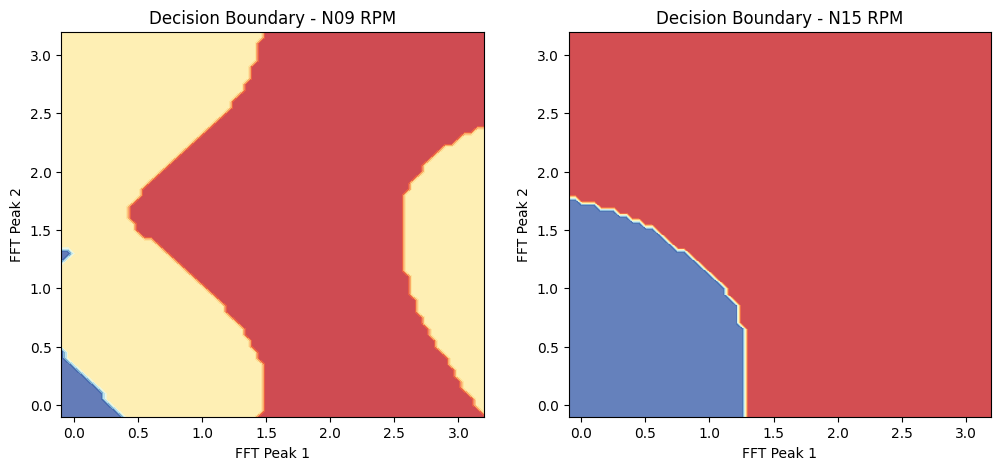

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

train_df = pd.read_csv('/content/drive/MyDrive/Padeborn_Dataset/train_fft_quantum.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Padeborn_Dataset/test_fft_quantum.csv')

scaler_fft = MinMaxScaler(feature_range=(0, np.pi))
scaler_rpm = MinMaxScaler(feature_range=(0, 1))

fft_cols = ['p1', 'p2', 'p3', 'p4']
train_df[fft_cols] = scaler_fft.fit_transform(train_df[fft_cols])
test_df[fft_cols] = scaler_fft.transform(test_df[fft_cols])
train_df[['rpm']] = scaler_rpm.fit_transform(train_df[['rpm']])
test_df[['rpm']] = scaler_rpm.transform(test_df[['rpm']])

X_train_fft = torch.tensor(train_df[fft_cols].values, dtype=torch.float32)
X_train_rpm = torch.tensor(train_df[['rpm']].values, dtype=torch.float32)
y_train = torch.tensor(train_df['label'].values, dtype=torch.long)

X_test_fft = torch.tensor(test_df[fft_cols].values, dtype=torch.float32)
X_test_rpm = torch.tensor(test_df[['rpm']].values, dtype=torch.float32)
y_test = torch.tensor(test_df['label'].values, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_fft, X_train_rpm, y_train), batch_size=16, shuffle=True)

n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def q_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(q_circuit, {"weights": (6, n_qubits, 3)})
        self.rpm_net = nn.Sequential(
            nn.Linear(1, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        self.post_process = nn.Sequential(
            nn.Linear(12, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4)
        )

    def forward(self, fft, rpm):
        q_out = self.qlayer(fft)
        r_out = self.rpm_net(rpm)
        combined = torch.cat((q_out, r_out), dim=1)
        return self.post_process(combined)

model = HybridModel()
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

for epoch in range(30):
    model.train()
    for b_fft, b_rpm, b_y in train_loader:
        optimizer.zero_grad()
        outputs = model(b_fft, b_rpm)
        loss = criterion(outputs, b_y)
        loss.backward()
        optimizer.step()
    scheduler.step()

def plot_decision_boundaries(model, rpm_value, title):
    h = .05
    x_min, x_max = -0.1, np.pi + 0.1
    y_min, y_max = -0.1, np.pi + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    grid_points = np.c_[xx.ravel(), yy.ravel()]
    dummy_features = np.zeros((grid_points.shape[0], 2))
    full_grid = np.hstack([grid_points, dummy_features])

    model.eval()
    with torch.no_grad():
        grid_tensor = torch.tensor(full_grid, dtype=torch.float32)
        rpm_tensor = torch.full((grid_tensor.shape[0], 1), rpm_value, dtype=torch.float32)
        logits = model(grid_tensor, rpm_tensor)
        preds = torch.argmax(logits, dim=1).reshape(xx.shape)

    plt.contourf(xx, yy, preds, alpha=0.8, cmap=plt.cm.RdYlBu)
    plt.title(title)
    plt.xlabel('FFT Peak 1')
    plt.ylabel('FFT Peak 2')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_decision_boundaries(model, 0.0, "Decision Boundary - N09 RPM")
plt.subplot(1, 2, 2)
plot_decision_boundaries(model, 1.0, "Decision Boundary - N15 RPM")
plt.show()